In [1]:
from datetime import datetime
from uuid import uuid4

from ipynb.fs.full.quantumsystem import qs, System, IntegerSystem, MetaSystem

In [2]:
class GameEventObject(System):
    """ Connects a game object to the gamestate """

class RoundCount(IntegerSystem):
    """ Records the number of rounds since the game began """

class GameEventTime(System):
    """ Which Team Is Active"""

class GameEventType(System):
    """ Which Team Is Active"""
    
class GameEventFaction(System):
    """ Which Team Is Active"""
    
class GameEventValue(System):
    """ Which Team Is Active"""
    
class GameEventResult(System):
    """ Which Team Is Active"""


@GameEventResult.sd
@GameEventValue.sd
@GameEventObject.sd
@GameEventFaction.sd
@GameEventType.sd
@RoundCount.sd
class GameEvent(MetaSystem):
    """ Game Event Record """

    @classmethod
    def meta_anchor(cls, anchor):
        return f"{cls.__name__}--{uuid4()}--{datetime.utcnow().isoformat().replace(':', '_')}"

    @classmethod
    @GameEventResult.decorator("gameEvent")
    def set_result(cls, gameEvent, newResult, gameeventresult):
        if gameeventresult != "null":
            raise Exception("Can only set null results")
        GameEventResult.set_relationship(gameEvent, newResult)

    @classmethod
    def get_events(cls, terminant="DeclaredEvents"):
        return [r[0] for r in qs.get(edge_name=GameEvent, terminant=terminant)]

    @classmethod
    def get_declared_events(cls):
        return cls.get_events("DeclaredEvents")

    @classmethod
    def get_resolved_events(cls):
        return cls.get_events("ResolvedEvents")

    @classmethod
    def move_event(cls, gameEvent, oldAnchor, newAnchor):
        qs.drop(gameEvent, cls.__name__, oldAnchor)
        qs.put(gameEvent, cls.__name__, newAnchor)

    @classmethod
    def declare_event(cls, **kwargs):
        return cls("DeclaredEvents", **kwargs)

    @classmethod
    def resolve_event(cls, gameEvent, result):
        cls.set_result(gameEvent=gameEvent, newResult=result)
        cls.move_event(gameEvent=gameEvent, oldAnchor="DeclaredEvents", newAnchor="ResolvedEvents")

    def resolve(self, result):
        self.resolve_event(self.meta_anchor, result)

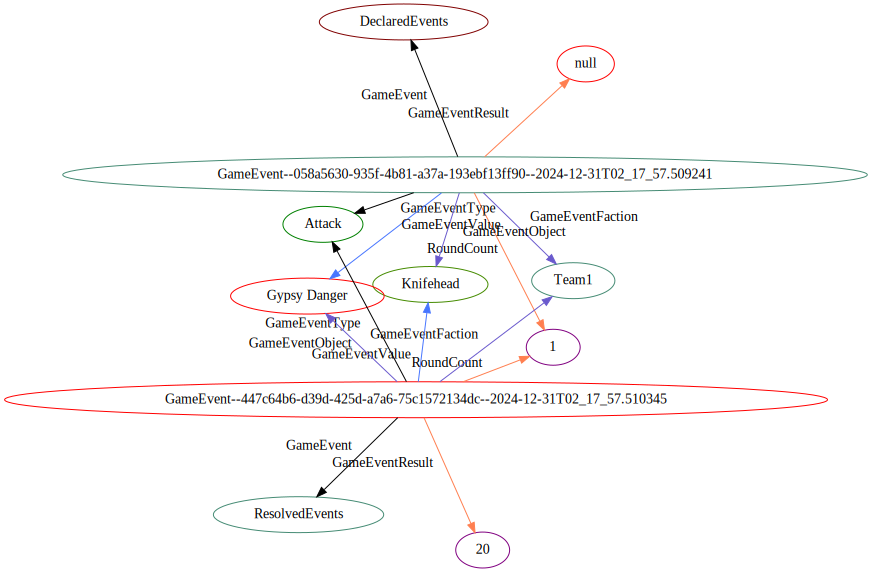

In [3]:
if __name__ == "__main__":
    from IPython.display import display

    qs.reset()
    GameEvent("DeclaredEvents", **{
        "RoundCount": "1",
        "GameEventType": "Attack",
        "GameEventFaction": "Team1",
        "GameEventObject": "Knifehead",
        "GameEventValue": "Gypsy Danger",
        "GameEventResult": "null"})
    event = GameEvent("DeclaredEvents", **{
        "RoundCount": "1",
        "GameEventType": "Attack",
        "GameEventFaction": "Team1",
        "GameEventObject": "Gypsy Danger",
        "GameEventValue": "Knifehead",
        "GameEventResult": "null"})
    assert len(GameEvent.get_declared_events()) == 2
    event.resolve("20")
    assert len(GameEvent.get_events("DeclaredEvents")) == 1
    assert len(GameEvent.get_resolved_events()) == 1
    assert event.meta_anchor in GameEvent.get_resolved_events()
    display(qs.render())